# SYNC BOUND SUM - DOUBLE EXTRA PRODUCTION

In [1]:
import sys
sys.path.append('../../../')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import redis
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6, 6)
import tensorflow as tf
import numpy as np
from evaluations.variables import upper_bound, lower_bound
from distribution.watcher import SynchronousBoundSum, NoSynchronization
from machine_learning.models import DoubleExtraProduction
tf.random.set_seed(42)

In [2]:
model = DoubleExtraProduction()


Load database helpers

In [3]:
r = redis.Redis(host='localhost', port=6379, db=0)

def sum(lst):
    sum = 0
    for i in lst:
        sum += float(i.decode("utf-8"))
    return sum

def avg(lst):
    sum = 0
    for i in lst:
        if type(i) != float:
            sum += float(i.decode("utf-8"))
        else:
            sum += i
    return sum / len(lst)

import math 

def std_deviation(lst):
    mean = avg(lst)
    sum = 0
    for i in lst:
        if type(i) != float:
            sum += (float(i.decode("utf-8")) - mean)**2
        else:
            sum += (i - mean)**2
    return math.sqrt(sum / len(lst))

def func_f1_score(lst1, lst2):
    res = []
    for prc, rc in zip(lst1, lst2):
        if type(prc) != float or type(rc) != float:
            prc = float(prc.decode("utf-8"))
            rc = float(rc.decode("utf-8"))

        res.append(2 * (prc * rc) / (prc + rc))
    return res
    

In [4]:
loss = {}
recall = {}
precision = {}
f1_score = {}
auc = {}
throughput = {}
total_time = {}
avg_pass_time = {}
read_time = {}
write_time = {}
tp = {}
tn = {}
fp = {}
fn = {}

loss_dev = {}
recall_dev = {}
precision_dev = {}
f1_score_dev = {}
auc_dev = {}
throughput_dev = {}
total_time_dev = {}
avg_pass_time_dev = {}
read_time_dev = {}
write_time_dev = {}
tp_dev = {}
tn_dev = {}
fp_dev = {}
fn_dev = {}

In [5]:
threshold_limit = [1, 2, 4, 8, 16, 32, 64, 128,256, 512, 1024]
num_workers = [2, 4, 8]
x_scale = ["1", "2", "4", "8", "16", "32", "64", "128","256", "512", "1024", "no\nsync"]

## First run

In [6]:

for i in num_workers:    
    tp[i] = [sum(r.lrange(f'v1_{model.name}_{SynchronousBoundSum.name}: TP_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    tp[i].append(sum(r.lrange(f'v1_{model.name}_{NoSynchronization.name}: TP_thres_{1}_pool_{i}', 0, -1)))
    
    tn[i] = [sum(r.lrange(f'v1_{model.name}_{SynchronousBoundSum.name}: TN_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    tn[i].append(sum(r.lrange(f'v1_{model.name}_{NoSynchronization.name}: TN_thres_{1}_pool_{i}', 0, -1)))
    
    fp[i] = [sum(r.lrange(f'v1_{model.name}_{SynchronousBoundSum.name}: FP_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    fp[i].append(sum(r.lrange(f'v1_{model.name}_{NoSynchronization.name}: FP_thres_{1}_pool_{i}', 0, -1)))
    
    fn[i] = [sum(r.lrange(f'v1_{model.name}_{SynchronousBoundSum.name}: FN_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    fn[i].append(sum(r.lrange(f'v1_{model.name}_{NoSynchronization.name}: FN_thres_{1}_pool_{i}', 0, -1)))

    loss[i] = [avg(r.lrange(f'v1_{model.name}_{SynchronousBoundSum.name}: Loss_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    loss[i].append(avg(r.lrange(f'v1_{model.name}_{NoSynchronization.name}: Loss_thres_{1}_pool_{i}', 0, -1)))

    precision[i] = [avg(r.lrange(f'v1_{model.name}_{SynchronousBoundSum.name}: Precision_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    precision[i].append(avg(r.lrange(f'v1_{model.name}_{NoSynchronization.name}: Precision_thres_{1}_pool_{i}', 0, -1)))
    
    recall[i] = [avg(r.lrange(f'v1_{model.name}_{SynchronousBoundSum.name}: Recall_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    recall[i].append(avg(r.lrange(f'v1_{model.name}_{NoSynchronization.name}: Recall_thres_{1}_pool_{i}', 0, -1)))

    f1_score[i] = [avg(func_f1_score(
        r.lrange(f'v1_{model.name}_{SynchronousBoundSum.name}: Precision_thres_{thr}_pool_{i}', 0, -1),
        r.lrange(f'v1_{model.name}_{SynchronousBoundSum.name}: Recall_thres_{thr}_pool_{i}', 0, -1)
        )) for thr in threshold_limit]
    f1_score[i].append(avg(func_f1_score(
            r.lrange(f'v1_{model.name}_{NoSynchronization.name}: Precision_thres_{1}_pool_{i}', 0, -1),
            r.lrange(f'v1_{model.name}_{NoSynchronization.name}: Recall_thres_{1}_pool_{i}', 0, -1)
    )))

    auc[i] = [avg(r.lrange(f'v1_{model.name}_{SynchronousBoundSum.name}: Auc_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    auc[i].append(avg(r.lrange(f'v1_{model.name}_{NoSynchronization.name}: Auc_thres_{1}_pool_{i}', 0, -1)))
    
    throughput[i] = [avg(r.lrange(f'v1_{model.name}_{SynchronousBoundSum.name}: Throughput_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    throughput[i].append(avg(r.lrange(f'v1_{model.name}_{NoSynchronization.name}: Throughput_thres_{1}_pool_{i}', 0, -1)))
    
    total_time[i] = [avg(r.lrange(f'v1_{model.name}_{SynchronousBoundSum.name}: TotalTime_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    total_time[i].append(avg(r.lrange(f'v1_{model.name}_{NoSynchronization.name}: TotalTime_thres_{1}_pool_{i}', 0, -1)))
    
    avg_pass_time[i] = [avg(r.lrange(f'v1_{model.name}_{SynchronousBoundSum.name}: AvgPass_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    avg_pass_time[i].append(avg(r.lrange(f'v1_{model.name}_{NoSynchronization.name}: AvgPass_thres_{1}_pool_{i}', 0, -1)))
    
    read_time[i] = [avg(r.lrange(f'v1_{model.name}_{SynchronousBoundSum.name}: read_time_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    read_time[i].append(avg(r.lrange(f'v1_{model.name}_{NoSynchronization.name}: read_time_thres_{1}_pool_{i}', 0, -1)))
    
    write_time[i] = [avg(r.lrange(f'v1_{model.name}_{SynchronousBoundSum.name}: write_time_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    write_time[i].append(avg(r.lrange(f'v1_{model.name}_{NoSynchronization.name}: write_time_thres_{1}_pool_{i}', 0, -1)))

In [7]:
for i in num_workers:
    loss_dev[i] = [std_deviation(r.lrange(f'v1_{model.name}_{SynchronousBoundSum.name}: Loss_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    loss_dev[i].append(std_deviation(r.lrange(f'v1_{model.name}_{NoSynchronization.name}: Loss_thres_{1}_pool_{i}', 0, -1)))

    precision_dev[i] = [std_deviation(r.lrange(f'v1_{model.name}_{SynchronousBoundSum.name}: Precision_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    precision_dev[i].append(std_deviation(r.lrange(f'v1_{model.name}_{NoSynchronization.name}: Precision_thres_{1}_pool_{i}', 0, -1)))
    
    recall_dev[i] = [std_deviation(r.lrange(f'v1_{model.name}_{SynchronousBoundSum.name}: Recall_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    recall_dev[i].append(std_deviation(r.lrange(f'v1_{model.name}_{NoSynchronization.name}: Recall_thres_{1}_pool_{i}', 0, -1)))
    
    f1_score_dev[i] = [std_deviation(func_f1_score(
        r.lrange(f'v1_{model.name}_{SynchronousBoundSum.name}: Precision_thres_{thr}_pool_{i}', 0, -1),
        r.lrange(f'v1_{model.name}_{SynchronousBoundSum.name}: Recall_thres_{thr}_pool_{i}', 0, -1)
        )) for thr in threshold_limit]
    f1_score_dev[i].append(std_deviation(func_f1_score(
            r.lrange(f'v1_{model.name}_{NoSynchronization.name}: Precision_thres_{1}_pool_{i}', 0, -1),
            r.lrange(f'v1_{model.name}_{NoSynchronization.name}: Recall_thres_{1}_pool_{i}', 0, -1)
    )))

    auc_dev[i] = [std_deviation(r.lrange(f'v1_{model.name}_{SynchronousBoundSum.name}: Auc_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    auc_dev[i].append(std_deviation(r.lrange(f'v1_{model.name}_{NoSynchronization.name}: Auc_thres_{1}_pool_{i}', 0, -1)))

    throughput_dev[i] = [std_deviation(r.lrange(f'v1_{model.name}_{SynchronousBoundSum.name}: Throughput_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    throughput_dev[i].append(std_deviation(r.lrange(f'v1_{model.name}_{NoSynchronization.name}: Throughput_thres_{1}_pool_{i}', 0, -1)))

    total_time_dev[i] = [std_deviation(r.lrange(f'v1_{model.name}_{SynchronousBoundSum.name}: TotalTime_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    total_time_dev[i].append(std_deviation(r.lrange(f'v1_{model.name}_{NoSynchronization.name}: TotalTime_thres_{1}_pool_{i}', 0, -1)))

    avg_pass_time_dev[i] = [std_deviation(r.lrange(f'v1_{model.name}_{SynchronousBoundSum.name}: AvgPass_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    avg_pass_time_dev[i].append(std_deviation(r.lrange(f'v1_{model.name}_{NoSynchronization.name}: AvgPass_thres_{1}_pool_{i}', 0, -1)))

    read_time_dev[i] = [std_deviation(r.lrange(f'v1_{model.name}_{SynchronousBoundSum.name}: read_time_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    read_time_dev[i].append(std_deviation(r.lrange(f'v1_{model.name}_{NoSynchronization.name}: read_time_thres_{1}_pool_{i}', 0, -1)))

    write_time_dev[i] = [std_deviation(r.lrange(f'v1_{model.name}_{SynchronousBoundSum.name}: write_time_thres_{thr}_pool_{i}', 0, -1)) for thr in threshold_limit]
    write_time_dev[i].append(std_deviation(r.lrange(f'v1_{model.name}_{NoSynchronization.name}: write_time_thres_{1}_pool_{i}', 0, -1)))



resutls

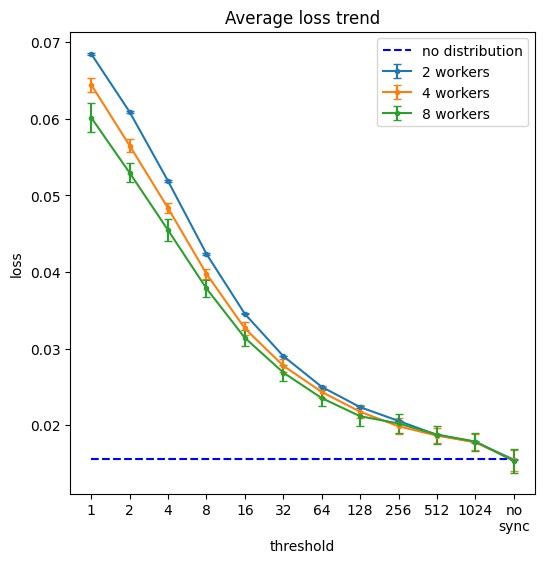

In [8]:
for i in num_workers:
    plt.errorbar(x_scale, loss[i], loss_dev[i], marker='.',label=f'{i} workers', capsize=3)
plt.plot(x_scale, [upper_bound['loss'][model.name] for _ in x_scale], 'b--', label=f'no distribution')
#plt.plot(x_scale, [lower_bound['loss'][model.name] for _ in x_scale], 'r--', label=f'randomized state')

plt.xlabel('threshold')
plt.ylabel('loss')
#plt.ylim(0,0.1)
plt.title('Average loss trend')
plt.legend(loc="upper right")
plt.savefig(f"../../../../image_results/{SynchronousBoundSum.name}_{model.name}_loss.png", format='png')
plt.show()


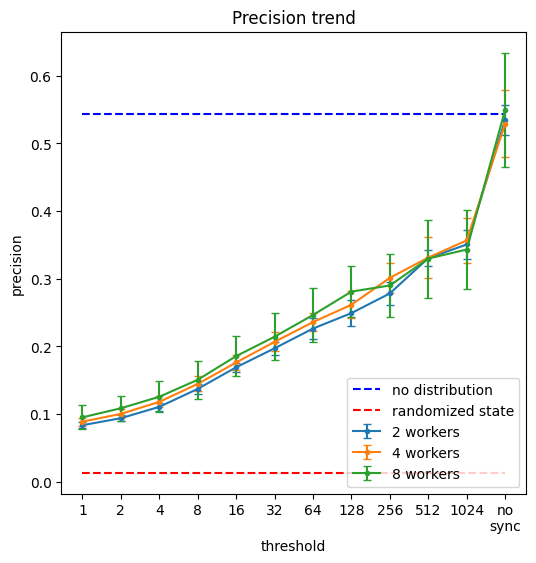

In [9]:
for i in num_workers:
    plt.errorbar(x_scale, precision[i], precision_dev[i], marker='.', label=f'{i} workers', capsize=3)
plt.plot(x_scale, [upper_bound['precision'][model.name] for _ in x_scale], 'b--', label=f'no distribution')
plt.plot(x_scale, [lower_bound['precision'][model.name] for _ in x_scale], 'r--', label=f'randomized state')
# plt.plot([0, 100], [prc_ub, prc_ub], 'b--', label=f'no distribution')
# plt.plot([0, 100], [prc_lb, prc_lb], 'r--', label=f'randomized state')

plt.xlabel('threshold')
plt.ylabel('precision')
plt.title('Precision trend')
plt.legend(loc="lower right")
plt.savefig(f"../../../../image_results/{SynchronousBoundSum.name}_{model.name}_precision.png", format='png')
plt.show()

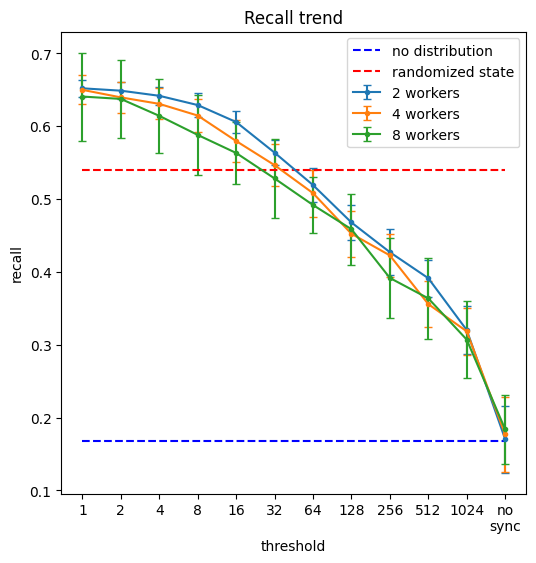

In [10]:
for i in num_workers:
    plt.errorbar(x_scale, recall[i], recall_dev[i], marker='.',label=f'{i} workers', capsize=3)
plt.plot(x_scale, [upper_bound['recall'][model.name] for _ in x_scale], 'b--', label=f'no distribution')
plt.plot(x_scale, [lower_bound['recall'][model.name] for _ in x_scale], 'r--', label=f'randomized state')
#plt.plot([0, 100], [rc_ub, rc_ub], 'b--', label=f'no distribution')
#plt.plot([0, 100], [rc_lb, rc_lb], 'r--', label=f'randomized state')

plt.xlabel('threshold')
plt.ylabel('recall')
plt.title('Recall trend')
plt.legend(loc="upper right")
plt.savefig(f"../../../../image_results/{SynchronousBoundSum.name}_{model.name}_recall.png", format='png')
plt.show()

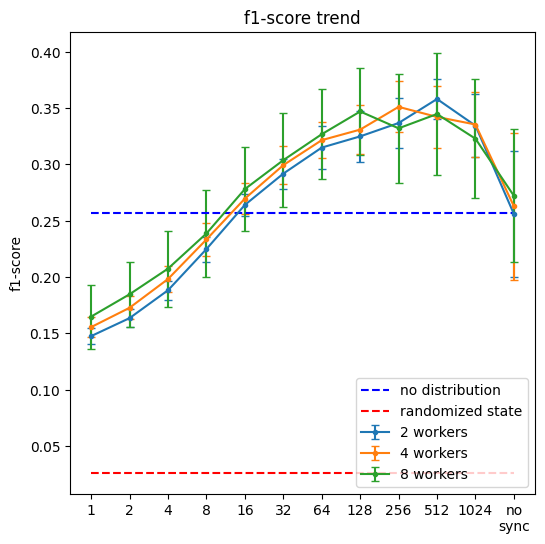

In [11]:
for i in num_workers:
    plt.errorbar(x_scale, f1_score[i], f1_score_dev[i], marker='.',label=f'{i} workers', capsize=3)
plt.plot(x_scale, [upper_bound['f1_score'][model.name] for _ in x_scale], 'b--', label=f'no distribution')
plt.plot(x_scale, [lower_bound['f1_score'][model.name] for _ in x_scale], 'r--', label=f'randomized state')
plt.ylabel('f1-score')
plt.title('f1-score trend')
plt.legend(loc="lower right")
plt.savefig(f"../../../../image_results/{SynchronousBoundSum.name}_{model.name}_f1_score.png", format='png')
plt.show()

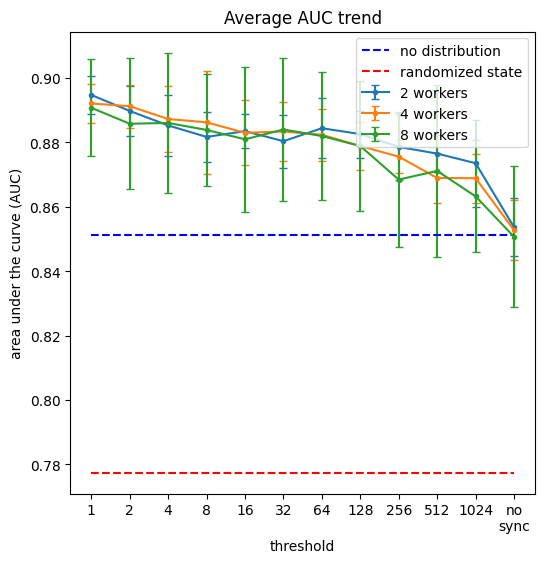

In [12]:
for i in num_workers:
    plt.errorbar(x_scale, auc[i], auc_dev[i], marker='.',label=f'{i} workers',capsize=3)
plt.plot(x_scale, [upper_bound['auc'][model.name] for _ in x_scale], 'b--', label=f'no distribution')
plt.plot(x_scale, [lower_bound['auc'][model.name] for _ in x_scale], 'r--', label=f'randomized state')

plt.xlabel('threshold')
plt.ylabel('area under the curve (AUC)')
plt.title('Average AUC trend')
#plt.ylim(0.9, 1)
plt.legend(loc="upper right")
plt.savefig(f"../../../../image_results/{SynchronousBoundSum.name}_{model.name}_auc.png", format='png')
plt.show()

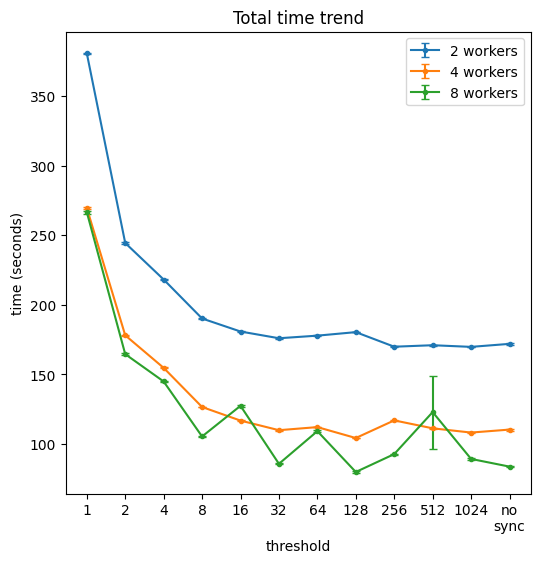

In [13]:
for i in num_workers:
    plt.errorbar(x_scale, total_time[i], total_time_dev[i], marker='.',label=f'{i} workers',capsize=3)

#plt.plot([0, 100], [rc_ub, rc_ub], 'b--', label=f'no distribution')
#plt.plot([0, 100], [rc_lb, rc_lb], 'r--', label=f'randomized state')

plt.xlabel('threshold')
plt.ylabel('time (seconds)')
plt.title('Total time trend')
plt.legend(loc="upper right")
plt.savefig(f"../../../../image_results/{SynchronousBoundSum.name}_{model.name}_total_time.png", format='png')

plt.show()

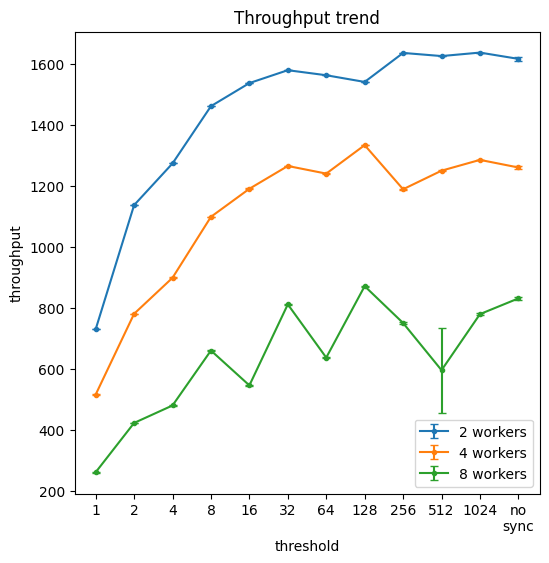

In [14]:
for i in num_workers:
    plt.errorbar(x_scale, throughput[i], throughput_dev[i], marker='.',label=f'{i} workers',capsize=3)
#plt.plot([0, 100], [rc_ub, rc_ub], 'b--', label=f'no distribution')
#plt.plot([0, 100], [rc_lb, rc_lb], 'r--', label=f'randomized state')

plt.xlabel('threshold')
plt.ylabel('throughput')
plt.title('Throughput trend')
plt.legend(loc="lower right")
plt.savefig(f"../../../../image_results/{SynchronousBoundSum.name}_{model.name}_throughput.png", format='png')
plt.show()

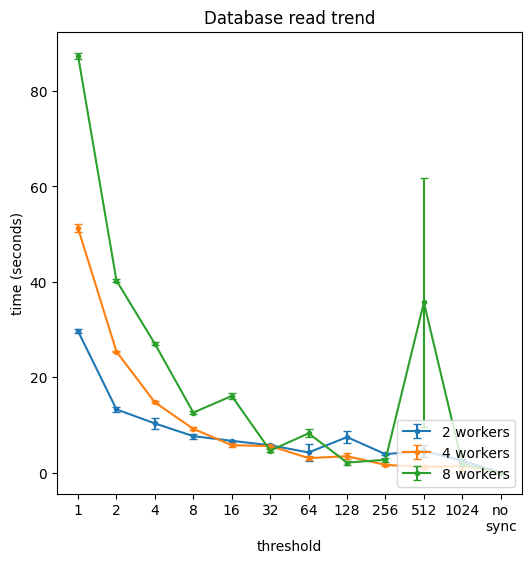

In [15]:
for i in num_workers:
    plt.errorbar(x_scale, read_time[i], read_time_dev[i], marker='.',label=f'{i} workers',capsize=3)
#plt.plot([0, 100], [rc_ub, rc_ub], 'b--', label=f'no distribution')
#plt.plot([0, 100], [rc_lb, rc_lb], 'r--', label=f'randomized state')

plt.xlabel('threshold')
plt.ylabel('time (seconds)')
plt.title('Database read trend')
plt.legend(loc="lower right")
plt.savefig(f"../../../../image_results/{SynchronousBoundSum.name}_{model.name}_read.png", format='png')
plt.show()

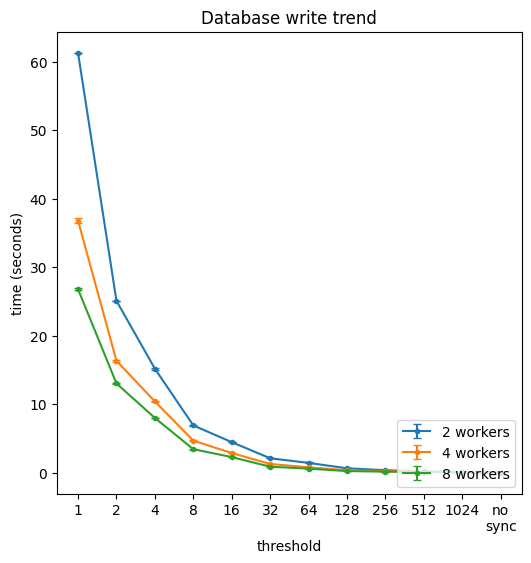

In [16]:
for i in num_workers:
    plt.errorbar(x_scale, write_time[i], write_time_dev[i],marker='.', label=f'{i} workers',capsize=3)
#plt.plot([0, 100], [rc_ub, rc_ub], 'b--', label=f'no distribution')
#plt.plot([0, 100], [rc_lb, rc_lb], 'r--', label=f'randomized state')

plt.xlabel('threshold')
plt.ylabel('time (seconds)')
plt.title('Database write trend')
plt.legend(loc="lower right")
plt.savefig(f"../../../../image_results/{SynchronousBoundSum.name}_{model.name}_write.png", format='png')
plt.show()